In [42]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# creating a def for monthly calculation 
def monthly(x, value):
    if x in ['409', '419', '619', '649']:
        return value * 30 / 365
    elif x in ['169', '219', '239', '249', '189', '269', '279', '199', '289', '299', '309', '319', '329']:
        return value * 30 / 7
    else:
        return value

In [26]:
def split_string(s):
    part0 = s[:13]   # first 2 bytes
    part1 = s[13:14]  # first 2 bytes
    part2 = s[14:16]  # next 2 bytes
    part3 = s[16:]   # remaining bytes
    return pd.Series([part0,part1, part2, part3]) 

In [3]:
col_specification=[(0,38),(38,39),(39,41),(41,46),(46,49),(49,59),(59,74)]
col_names=['Common-ID','Questionnaire No.','Level','Section','Item Code','Value (in Rs)','Multiplier']#,'Marital Status (code)','Highest educational level attained (code)','Total year of education completed','Whether used internet from any location during last 30 days']
lvl_14= pd.read_fwf(r'F:\DATA\D_work\Interpreation\hces22_lvl_14.txt', header=None, colspecs=col_specification, names = col_names)
lvl_14.head(8)

,Common-ID,Questionnaire No.,Level,Section,Item Code,Value (in Rs),Multiplier
0,HCES2022655621010121713017 101111 301,F,14,5.1,139,90,8890.0
1,HCES2022655621010121713017 101111 310,F,14,5.1,139,90,8890.0
2,HCES2022655621010121713017 101111 311,F,14,5.1,139,25,8890.0
3,HCES2022655621010121713017 101111 313,F,14,5.1,139,45,8890.0
4,HCES2022655371010122023014 201111 202,F,14,5.1,139,75,140500.0
5,HCES2022655261010122023016 101112 201,F,14,5.1,139,10,84300.0
6,HCES2022655261010122023016 101112 301,F,14,5.1,139,30,137525.0
7,HCES2022655261010122023016 101112 303,F,14,5.1,139,30,137525.0


In [4]:
level_14 = lvl_14.drop(['Level','Section'],axis=1)
level_14

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier
0,HCES2022655621010121713017 101111 301,F,139,90,8890.0
1,HCES2022655621010121713017 101111 310,F,139,90,8890.0
2,HCES2022655621010121713017 101111 311,F,139,25,8890.0
3,HCES2022655621010121713017 101111 313,F,139,45,8890.0
4,HCES2022655371010122023014 201111 202,F,139,75,140500.0
...,...,...,...,...,...
8075523,HCES20223492023737102120110201201 313,D,579,3450,938.0
8075524,HCES20223492023737102120110201201 313,D,599,1700,938.0
8075525,HCES20223492023737102120110201201 313,D,629,1280,938.0
8075526,HCES20223492023737102120110201201 313,D,639,5350,938.0


In [5]:
level_14['Monthly Value'] = level_14.apply(lambda row: monthly(row['Item Code'], row['Value (in Rs)']), axis=1)
level_14

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier,Monthly Value
0,HCES2022655621010121713017 101111 301,F,139,90,8890.0,90
1,HCES2022655621010121713017 101111 310,F,139,90,8890.0,90
2,HCES2022655621010121713017 101111 311,F,139,25,8890.0,25
3,HCES2022655621010121713017 101111 313,F,139,45,8890.0,45
4,HCES2022655371010122023014 201111 202,F,139,75,140500.0,75
...,...,...,...,...,...,...
8075523,HCES20223492023737102120110201201 313,D,579,3450,938.0,3450
8075524,HCES20223492023737102120110201201 313,D,599,1700,938.0,1700
8075525,HCES20223492023737102120110201201 313,D,629,1280,938.0,1280
8075526,HCES20223492023737102120110201201 313,D,639,5350,938.0,5350


In [6]:
# Calculating total expanditure on the base of monthly value
level_14['Total Expenditure'] = level_14['Monthly Value']*level_14['Multiplier']
level_14

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier,Monthly Value,Total Expenditure
0,HCES2022655621010121713017 101111 301,F,139,90,8890.0,90,800100.0
1,HCES2022655621010121713017 101111 310,F,139,90,8890.0,90,800100.0
2,HCES2022655621010121713017 101111 311,F,139,25,8890.0,25,222250.0
3,HCES2022655621010121713017 101111 313,F,139,45,8890.0,45,400050.0
4,HCES2022655371010122023014 201111 202,F,139,75,140500.0,75,10537500.0
...,...,...,...,...,...,...,...
8075523,HCES20223492023737102120110201201 313,D,579,3450,938.0,3450,3236100.0
8075524,HCES20223492023737102120110201201 313,D,599,1700,938.0,1700,1594600.0
8075525,HCES20223492023737102120110201201 313,D,629,1280,938.0,1280,1200640.0
8075526,HCES20223492023737102120110201201 313,D,639,5350,938.0,5350,5018300.0


In [7]:
col_specification=[(0,38),(38,39),(39,41),(41,42),(42,43),(43,58)]
col_names=['Common-ID','Questionnaire No.','Level','Survey Code','Reason for substitution Code','Multiplier']
lvl_1= pd.read_fwf(r'F:\DATA\D_work\Interpreation\hces22_lvl_01.txt', header=None, colspecs=col_specification, names = col_names)
lvl_1 = lvl_1.drop(['Questionnaire No.','Reason for substitution Code','Level','Survey Code'],axis=1)
lvl_1

,Common-ID,Multiplier
0,HCES2022655561010131113011 101202 201,35560.0
1,HCES2022655561010131113011 101202 301,30331.0
2,HCES2022655561010131113011 101202 302,30331.0
3,HCES2022655561010131113011 101202 303,30331.0
4,HCES2022655561010131113011 101202 304,30331.0
...,...,...
261741,HCES20223951022828313220210228101 314,73515.0
261742,HCES20223951022828313220210228101 315,73515.0
261743,HCES20223951022828313220210228101 316,73515.0
261744,HCES20223951022828313220210228101 317,73515.0


In [8]:
FDQ = level_14[level_14['Questionnaire No.'].isin(['F'])]
FDQ.head(5)

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier,Monthly Value,Total Expenditure
0,HCES2022655621010121713017 101111 301,F,139,90,8890.0,90,800100.0
1,HCES2022655621010121713017 101111 310,F,139,90,8890.0,90,800100.0
2,HCES2022655621010121713017 101111 311,F,139,25,8890.0,25,222250.0
3,HCES2022655621010121713017 101111 313,F,139,45,8890.0,45,400050.0
4,HCES2022655371010122023014 201111 202,F,139,75,140500.0,75,10537500.0


In [9]:
FDQ_new = FDQ.groupby('Common-ID')['Total Expenditure'].sum().to_frame()
FDQ_new.reset_index().head(5)

,Common-ID,Total Expenditure
0,HCES2022310002282831212025 228111 301,210269142.0
1,HCES2022310002282831212025 228111 302,408186540.0
2,HCES2022310002282831212025 228111 303,438969402.0
3,HCES2022310002282831212025 228111 304,198110394.0
4,HCES2022310002282831212025 228111 305,45161064.0


In [10]:
CSQ = level_14[level_14['Questionnaire No.'].isin(['C'])]
CSQ.head(5)

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier,Monthly Value,Total Expenditure
3149267,HCES2022655561010131113011 101202 201,C,349,1960,35560.0,1960,69697600.0
3149268,HCES2022655561010131113011 101202 301,C,349,1620,30331.0,1620,49136220.0
3149269,HCES2022655561010131113011 101202 302,C,349,1845,30331.0,1845,55960695.0
3149270,HCES2022655561010131113011 101202 303,C,349,1520,30331.0,1520,46103120.0
3149271,HCES2022655561010131113011 101202 304,C,349,1280,30331.0,1280,38823680.0


In [11]:
CSQ_new = CSQ.groupby('Common-ID')['Total Expenditure'].sum().to_frame()
CSQ_new.reset_index().head(5)

,Common-ID,Total Expenditure
0,HCES2022310002282831212025 228111 301,6.780914e+08
1,HCES2022310002282831212025 228111 302,6.411713e+09
2,HCES2022310002282831212025 228111 303,4.464576e+09
3,HCES2022310002282831212025 228111 304,1.088111e+09
4,HCES2022310002282831212025 228111 305,9.301442e+08


In [12]:
DGQ = level_14[level_14['Questionnaire No.'].isin(['D'])]
DGQ.head(5)

,Common-ID,Questionnaire No.,Item Code,Value (in Rs),Multiplier,Monthly Value,Total Expenditure
5689781,HCES2022655561010131113011 101202 201,D,379,8470,35560.0,8470,301193200.0
5689782,HCES2022655561010131113011 101202 201,D,389,1100,35560.0,1100,39116000.0
5689783,HCES2022655561010131113011 101202 201,D,399,2210,35560.0,2210,78587600.0
5689784,HCES2022655561010131113011 101202 301,D,379,7990,30331.0,7990,242344690.0
5689785,HCES2022655561010131113011 101202 301,D,389,1300,30331.0,1300,39430300.0


In [13]:
DGQ_new = DGQ.groupby('Common-ID')['Total Expenditure'].sum().to_frame()
DGQ_new.reset_index().head(5)

,Common-ID,Total Expenditure
0,HCES2022310002282831212025 228111 301,1.544643e+09
1,HCES2022310002282831212025 228111 302,3.729648e+09
2,HCES2022310002282831212025 228111 303,4.048091e+09
3,HCES2022310002282831212025 228111 304,2.161266e+09
4,HCES2022310002282831212025 228111 305,1.272809e+09


In [15]:
m_fdq = lvl_1.merge(FDQ_new, on='Common-ID', how='left').fillna(0).reset_index()
m_fdq_rnme = m_fdq.rename(columns={'count':'Total_mambers_in_a _household'})
m_fdq_rnme = m_fdq_rnme.rename(columns={'Total Expenditure':'FDQ_Expenditure'})
m_fdq_rnme = m_fdq_rnme.rename(columns={'Common-ID':'Common-ID'})
m_fdq_rnme.head(5)

,index,Common-ID,Multiplier,FDQ_Expenditure
0,0,HCES2022655561010131113011 101202 201,35560.0,180431440.0
1,1,HCES2022655561010131113011 101202 301,30331.0,133213752.0
2,2,HCES2022655561010131113011 101202 302,30331.0,165546598.0
3,3,HCES2022655561010131113011 101202 303,30331.0,111496756.0
4,4,HCES2022655561010131113011 101202 304,30331.0,104581288.0


In [16]:
m_csq = m_fdq_rnme.merge(CSQ_new, on='Common-ID', how='left').fillna(0)
m_csq_rnme = m_csq.rename(columns={'Total Expenditure':'CSQ_Expenditure'})
m_csq_rnme.head(5)

,index,Common-ID,Multiplier,FDQ_Expenditure,CSQ_Expenditure
0,0,HCES2022655561010131113011 101202 201,35560.0,180431440.0,1.229843e+09
1,1,HCES2022655561010131113011 101202 301,30331.0,133213752.0,1.111601e+09
2,2,HCES2022655561010131113011 101202 302,30331.0,165546598.0,1.060978e+09
3,3,HCES2022655561010131113011 101202 303,30331.0,111496756.0,7.682842e+08
4,4,HCES2022655561010131113011 101202 304,30331.0,104581288.0,1.242054e+08


In [23]:
m_dgq = m_csq_rnme.merge(DGQ_new, on='Common-ID', how='left').fillna(0)
m_dgq_rnme = m_dgq.rename(columns={'Total Expenditure':'DGQ_Expenditure'})
main = m_dgq_rnme.drop(['index'],axis=1)
main.head(5)

,Common-ID,Multiplier,FDQ_Expenditure,CSQ_Expenditure,DGQ_Expenditure
0,HCES2022655561010131113011 101202 201,35560.0,180431440.0,1.229843e+09,1.121918e+09
1,HCES2022655561010131113011 101202 301,30331.0,133213752.0,1.111601e+09,5.756824e+08
2,HCES2022655561010131113011 101202 302,30331.0,165546598.0,1.060978e+09,6.906369e+08
3,HCES2022655561010131113011 101202 303,30331.0,111496756.0,7.682842e+08,7.324936e+08
4,HCES2022655561010131113011 101202 304,30331.0,104581288.0,1.242054e+08,3.433469e+08


In [24]:
main['FDQ'] = main['FDQ_Expenditure']/main['Multiplier']
main['CSQ'] = main['CSQ_Expenditure']/main['Multiplier']
main['DGQ'] = main['DGQ_Expenditure']/main['Multiplier']
main = main.drop(['FDQ_Expenditure','CSQ_Expenditure','DGQ_Expenditure'],axis=1)
main.head(5)

,Common-ID,Multiplier,FDQ,CSQ,DGQ
0,HCES2022655561010131113011 101202 201,35560.0,5074.0,34585.0,31550.0
1,HCES2022655561010131113011 101202 301,30331.0,4392.0,36649.0,18980.0
2,HCES2022655561010131113011 101202 302,30331.0,5458.0,34980.0,22770.0
3,HCES2022655561010131113011 101202 303,30331.0,3676.0,25330.0,24150.0
4,HCES2022655561010131113011 101202 304,30331.0,3448.0,4095.0,11320.0


In [30]:
st = lvl_1.copy()
st[['part0','part1', 'part2', 'part3']] = st['Common-ID'].apply(split_string)
st

,Common-ID,Multiplier,part0,part1,part2,part3
0,HCES2022655561010131113011 101202 201,35560.0,HCES202265556,1,01,0131113011 101202 201
1,HCES2022655561010131113011 101202 301,30331.0,HCES202265556,1,01,0131113011 101202 301
2,HCES2022655561010131113011 101202 302,30331.0,HCES202265556,1,01,0131113011 101202 302
3,HCES2022655561010131113011 101202 303,30331.0,HCES202265556,1,01,0131113011 101202 303
4,HCES2022655561010131113011 101202 304,30331.0,HCES202265556,1,01,0131113011 101202 304
...,...,...,...,...,...,...
261741,HCES20223951022828313220210228101 314,73515.0,HCES202239510,2,28,28313220210228101 314
261742,HCES20223951022828313220210228101 315,73515.0,HCES202239510,2,28,28313220210228101 315
261743,HCES20223951022828313220210228101 316,73515.0,HCES202239510,2,28,28313220210228101 316
261744,HCES20223951022828313220210228101 317,73515.0,HCES202239510,2,28,28313220210228101 317


In [31]:
st_copy = st.drop(['Multiplier','part0','part3'],axis=1)
st_copy

,Common-ID,part1,part2
0,HCES2022655561010131113011 101202 201,1,01
1,HCES2022655561010131113011 101202 301,1,01
2,HCES2022655561010131113011 101202 302,1,01
3,HCES2022655561010131113011 101202 303,1,01
4,HCES2022655561010131113011 101202 304,1,01
...,...,...,...
261741,HCES20223951022828313220210228101 314,2,28
261742,HCES20223951022828313220210228101 315,2,28
261743,HCES20223951022828313220210228101 316,2,28
261744,HCES20223951022828313220210228101 317,2,28


In [32]:
st_copy_1 = st_copy.rename(columns={'part1':'Sector'})
st_copy_2= st_copy_1.rename(columns={'part2':'State'})
New_main = main.merge(st_copy_2, on='Common-ID', how='left').fillna(0)
New_main

,Common-ID,Multiplier,FDQ,CSQ,DGQ,Sector,State
0,HCES2022655561010131113011 101202 201,35560.0,5074.0,34585.0,31550.0,1,01
1,HCES2022655561010131113011 101202 301,30331.0,4392.0,36649.0,18980.0,1,01
2,HCES2022655561010131113011 101202 302,30331.0,5458.0,34980.0,22770.0,1,01
3,HCES2022655561010131113011 101202 303,30331.0,3676.0,25330.0,24150.0,1,01
4,HCES2022655561010131113011 101202 304,30331.0,3448.0,4095.0,11320.0,1,01
...,...,...,...,...,...,...,...
261741,HCES20223951022828313220210228101 314,73515.0,2019.0,9340.0,139030.0,2,28
261742,HCES20223951022828313220210228101 315,73515.0,3844.0,119280.0,58850.0,2,28
261743,HCES20223951022828313220210228101 316,73515.0,2638.0,21639.0,27249.0,2,28
261744,HCES20223951022828313220210228101 317,73515.0,3713.0,13930.0,29980.0,2,28


In [33]:
check = New_main[New_main['Sector'].isin(['1'])]
check.head(5)

,Common-ID,Multiplier,FDQ,CSQ,DGQ,Sector,State
0,HCES2022655561010131113011 101202 201,35560.0,5074.0,34585.0,31550.0,1,01
1,HCES2022655561010131113011 101202 301,30331.0,4392.0,36649.0,18980.0,1,01
2,HCES2022655561010131113011 101202 302,30331.0,5458.0,34980.0,22770.0,1,01
3,HCES2022655561010131113011 101202 303,30331.0,3676.0,25330.0,24150.0,1,01
4,HCES2022655561010131113011 101202 304,30331.0,3448.0,4095.0,11320.0,1,01


In [61]:
x = New_main['State']
y = New_main['FDQ']
z = New_main['DGQ']
w = New_main['CSQ']

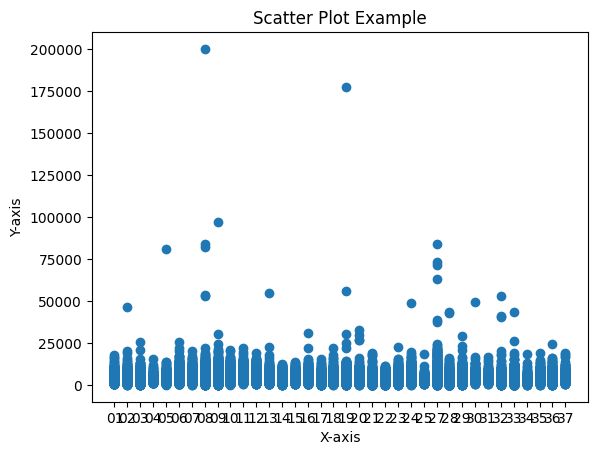

In [60]:
# Create the scatter plot
plt.scatter(x, y)

# Add title and labels
plt.title("Scatter Plot Example")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

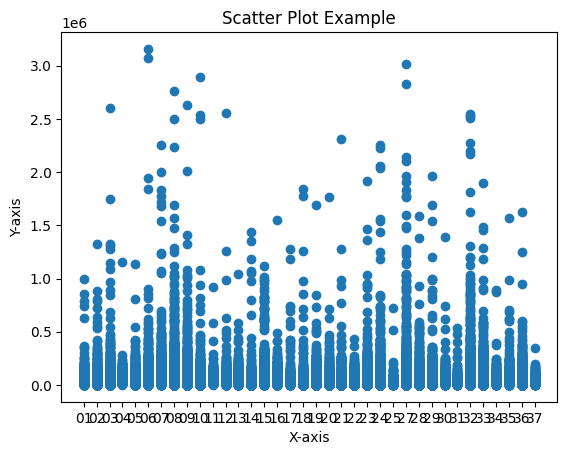

In [62]:
# Create the scatter plot
plt.scatter(x, z)

# Add title and labels
plt.title("Scatter Plot Example")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()

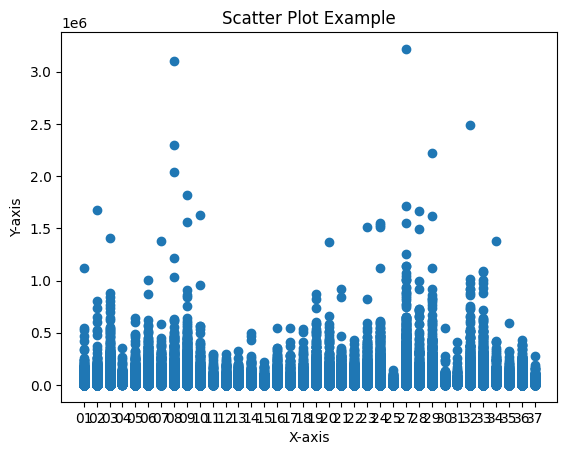

In [63]:
# Create the scatter plot
plt.scatter(x, w)

# Add title and labels
plt.title("Scatter Plot Example")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")

# Show the plot
plt.show()